# 传统的去阴影方法

> 我们将在这里使用一些传统的图像去阴影的方法，并与基于深度学习的方法做一些简单的对比

> 我们主要用的是`open cv`来调用一些傅里叶变化、高斯模糊等过程


## 图像背景差分（Background Subtraction）

将读入的彩色图像拆分成三个不同的灰度通道，对每个通道进行如下处理：

1. 膨胀操作：用大小为 (7,7) 的矩形结构元素对当前灰度通道进行膨胀操作，使图像中的每个物体更加紧密。

2. 中值滤波：用大小为 (21,21) 的方形窗口对当前灰度通道进行中值滤波，以去除一些随机的噪声。

3. 差分操作：用中值滤波后的图像减去原图像，得到差分图像。

4. 归一化操作：将得到的差分图像通过线性变换映射到 [0, 255] 的像素值范围内，从而得到归一化后的图像。这一步操作可以调整图像对比度，使前景物体更加明显。

In [1]:
import cv2
import numpy as np

img = cv2.imread('../images/model-result/A-100-1.png', -1)

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imwrite('../images/tradition/100-1-Background-Subtraction.png', result)
cv2.imwrite('../images/tradition/100-1-Background-Subtraction-norm.png', result_norm)




True

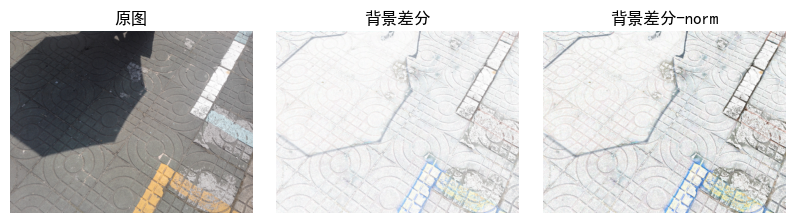

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'

# 创建2x5的子图网格
fig, axs = plt.subplots(1, 3,figsize=(10, 6))

# 指定每个子图的位置和标签
positions = [(0, 0, '原图'), (0, 1, '背景差分'), 
             (0, 2, '背景差分-norm')
             ]

img_path = ['../images/model-result/A-100-1.png','../images/tradition/100-1-Background-Subtraction.png',
            '../images/tradition/100-1-Background-Subtraction-norm.png',
            ]
# 加载并显示每个子图的PNG图片
for i,position in enumerate(positions):
    path = img_path[i]
    img = plt.imread(path)
    axs[position[1]].imshow(img)
    axs[position[1]].set_title(position[2])
    axs[position[1]].axis('off')

# 调整子图之间的间距和外边距
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.margins(0, 0)

# 展示图形
plt.show()

# 直方图均衡化

步骤是将彩色图像转换为灰度图像，并通过直方图均衡化增强图像的对比度和亮度，可以看到结果并不是很好

In [3]:
def method_v1(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(img)

    return res

img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = method_v1(img)
cv2.imwrite('../images/tradition/100-1-histogram-equalization.png', img_output)

True

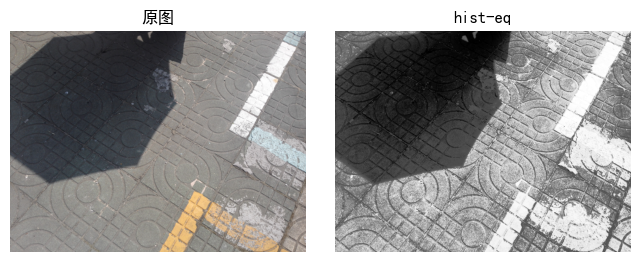

In [4]:
# 创建2x5的子图网格
fig, axs = plt.subplots(1, 2,figsize=(8, 6))

# 指定每个子图的位置和标签
positions = [(0, 0, '原图'), (0, 1, 'hist-eq')
             ]

img_path = ['../images/model-result/A-100-1.png','../images/tradition/100-1-histogram-equalization.png'
            ]
# 加载并显示每个子图的PNG图片
for i,position in enumerate(positions):
    path = img_path[i]
    img = plt.imread(path)
    axs[position[1]].imshow(img,cmap='gray')
    axs[position[1]].set_title(position[2])
    axs[position[1]].axis('off')

# 调整子图之间的间距和外边距
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.margins(0, 0)

# 展示图形
plt.show()

## clahe

通过 `cv2.createCLAHE` 函数指定了 `clipLimit` 参数为`2.0`，这个参数控制了对比度限制的程度。

还通过 `tileGridSize` 参数设置均衡化操作的区域大小，默认为(8, 8)。

效果也一般，需要手动去试参数

True

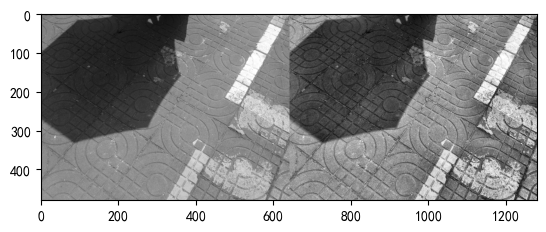

In [5]:
def method_v2(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Less 'clipLimit' value less effect
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    res = clahe.apply(img)

    img = np.hstack([img, res])

    return img

img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = method_v2(img)
plt.imshow(img_output,cmap='gray')
cv2.imwrite('../images/tradition/100-1-clahe.png', img_output)

## GAMMA

基于灰度图像的增强方法，主要通过Gamma校正来调整图像的亮度和对比度。

True

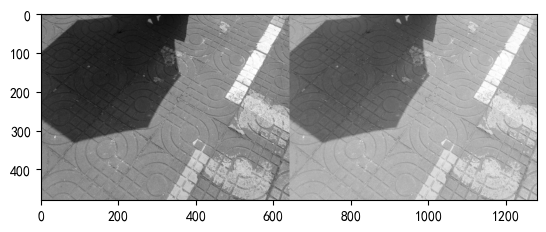

In [6]:
def method_v3(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gamma = 0.6
    res = np.power((img / 255.0), gamma) * 255
    res = np.clip(res, 0, 255).astype(np.uint8)

    img = np.hstack([img, res])

    return img

img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = method_v3(img)
plt.imshow(img_output,cmap='gray')
cv2.imwrite('../images/tradition/100-1-gamma.png', img_output)

## CLAHE-grid

使用不同网格尺寸的CLAHE对象对灰度图像进行增强。通过在不同尺寸的网格上进行CLAHE处理，可以产生多个增强后的图像，从而突出显示不同尺寸下的图像细节和对比度变化。

True

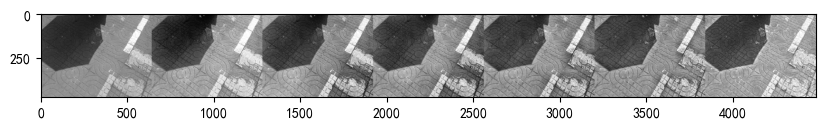

In [7]:
def create_clahe_grid_v1(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    grid_size = [1, 2, 4, 8, 16, 32]

    res_list = []
    res_list.append(img)
    for sz in grid_size:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(sz, sz))
        res = clahe.apply(img)
        res_list.append(res)

    img = np.hstack(res_list)

    return img

fig = plt.figure(figsize=(10,3))
img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = create_clahe_grid_v1(img)
plt.imshow(img_output,cmap='gray')
cv2.imwrite('../images/tradition/100-1-clahe-grid.png', img_output)

## CLAHE-grid-v2

使用不同对比度限制值的CLAHE对象对灰度图像进行增强。
通过在不同对比度限制下进行CLAHE处理，产生多个增强后的图像。

True

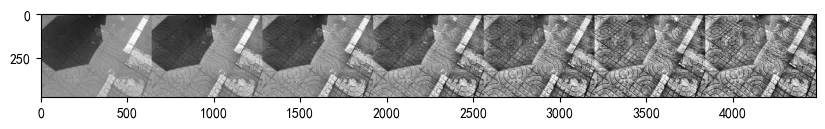

In [8]:
def create_clahe_grid_v2(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    clip_limit = [1, 2, 4, 8, 16, 32]

    res_list = []
    res_list.append(img)
    for cl in clip_limit:
        clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(8, 8))
        res = clahe.apply(img)
        res_list.append(res)

    img = np.hstack(res_list)

    return img

fig = plt.figure(figsize=(10,3))
img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = create_clahe_grid_v2(img)
plt.imshow(img_output,cmap='gray')
cv2.imwrite('../images/tradition/100-1-clahe-grid-v2.png', img_output)


## gamma-grid

使用不同gamma参数值对灰度图像进行伽马校正。通过调整图像亮度，产生多个增强后的图像。

True

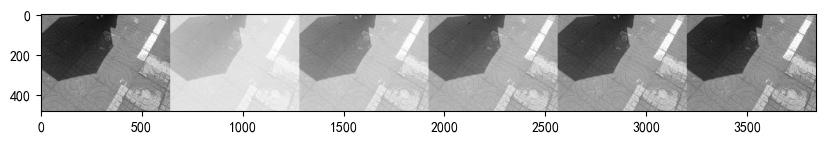

In [9]:
def create_gamma_correction_grid_v1(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    res_list = []
    res_list.append(img)
    gamma_list = [0.2, 0.4, 0.6, 0.8, 1.0] # lighter
    #gamma_list = [1.2, 1.4, 1.6, 1.8, 2.0] # darker
    for gamma in gamma_list:
        res = np.power((img / 255.0), gamma) * 255
        res = np.clip(res, 0, 255).astype(np.uint8)
        res_list.append(res)

    img = np.hstack(res_list)

    return img

fig = plt.figure(figsize=(10,3))
img = cv2.imread('../images/model-result/A-100-1.png', -1)
img_output = create_gamma_correction_grid_v1(img)
plt.imshow(img_output,cmap='gray')
cv2.imwrite('../images/tradition/100-1-gamma-grid.png', img_output)


## 总结

> 可以发现传统方法的效果很大程度上取决于参数，比如CLAHE的窗口大小和剪切值。
> 而基于深度学习的方法就无需认为调参，就会有更好的效果。